# Auditoría de series temporales agrícolas con Denoising Autoencoders

Este notebook presenta un flujo metodológico para la **auditoría de calidad de series temporales agrícolas**
basadas en índices satelitales (NDVI, NDMI) y variables climáticas.

El objetivo no es predecir rendimiento ni recomendar manejo agronómico, sino **evaluar la confiabilidad
de los datos de entrada**, distinguiendo entre:
- ruido de observación (nubosidad, baja cantidad de imágenes, artefactos)
- eventos ecofisiológicos reales del sistema productivo

El método se basa en **Denoising Autoencoders temporales (LSTM)**, entrenados para aprender la dinámica
normal del sistema y detectar observaciones inconsistentes.


## Flujo general del método

```text
NDVI / NDMI crudo + variables climáticas
                ↓
      Auditoría DL (DAE – LSTM)
                ↓
      Score de anomalía temporal
                ↓
Dato confiable       |       Dato sospechoso
                ↓
     Serie temporal auditada
                ↓
 Modelos productivos / análisis posteriores


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam


In [23]:
# Carga del dataset de ejemplo
df = pd.read_csv("data/example_dataset.csv", parse_dates=["date"])

df.head()


## Diagnóstico inicial de la serie temporal

Antes de aplicar cualquier modelo, se realiza una inspección básica para:
- verificar continuidad temporal
- detectar valores faltantes
- evaluar rangos de las variables principales

Este paso es clave para evitar interpretar ruido como señal biológica.


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          73 non-null     datetime64[ns]
 1   NDVI          73 non-null     float64       
 2   NDMI          73 non-null     float64       
 3   Cloud_Median  73 non-null     float64       
 4   Num_Imgs      73 non-null     int64         
 5   Precip        73 non-null     float64       
 6   Tmin          73 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.1 KB


In [5]:
df.describe()


,date,NDVI,NDMI,Cloud_Median,Num_Imgs,Precip,Tmin
count,73,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,2022-04-17 09:12:19.726027520,0.623662,0.208379,5.745782,2.794521,1.234589,7.915068
min,2019-01-01 00:00:00,0.362396,0.103986,0.002694,1.000000,0.000000,-4.900000
25%,2020-09-01 00:00:00,0.595957,0.172772,0.273473,2.000000,0.000000,4.200000
50%,2022-04-01 00:00:00,0.630886,0.210747,2.725751,3.000000,0.000000,6.900000
75%,2024-01-01 00:00:00,0.671789,0.242215,8.664195,4.000000,0.000000,12.100000
max,2025-07-01 00:00:00,0.771770,0.338914,27.056566,6.000000,19.500000,20.600000
std,NaN,0.077526,0.053716,6.905336,1.353585,4.196476,5.614921


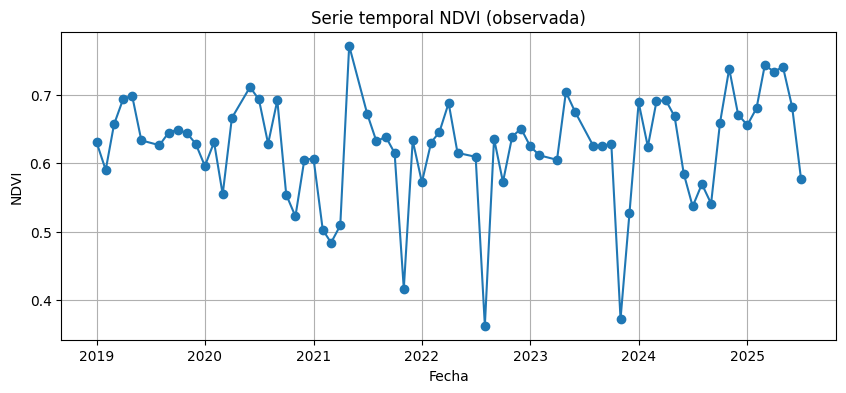

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["NDVI"], marker="o")
plt.title("Serie temporal NDVI (observada)")
plt.xlabel("Fecha")
plt.ylabel("NDVI")
plt.grid(True)
plt.show()


## Construcción del dataset final

Para la auditoría mediante Deep Learning se seleccionan únicamente las variables
relevantes para describir la dinámica ecofisiológica del sistema y la calidad
de observación.

En esta etapa:
- se eliminan columnas no utilizadas
- se controlan valores faltantes
- se construye una matriz numérica coherente para ML / DL


In [7]:
features = [
    "NDVI",
    "NDMI",
    "Cloud_Median",
    "Num_Imgs",
    "Precip",
    "Tmin"
]

df_model = df[["date"] + features].copy()
df_model.head()


,date,NDVI,NDMI,Cloud_Median,Num_Imgs,Precip,Tmin
0,2019-01-01,0.630886,0.189088,1.146589,4,0.0,17.4
1,2019-02-01,0.590109,0.132572,8.512739,5,0.0,15.1
2,2019-03-01,0.656709,0.214589,3.793154,2,0.0,10.2
3,2019-04-01,0.694126,0.252951,10.125660,4,0.0,12.9
4,2019-05-01,0.698659,0.236078,6.393467,2,19.5,1.9


## Manejo de valores faltantes

Dado que el objetivo es auditar la serie y no maximizar performance predictiva,
se aplica una estrategia simple y transparente para los valores faltantes,
evitando interpolaciones complejas que puedan introducir sesgos.


In [8]:
df_model.isna().sum()


,0
date,0
NDVI,0
NDMI,0
Cloud_Median,0
Num_Imgs,0
Precip,0
Tmin,0


In [9]:
# Eliminación de filas con valores faltantes
df_model_clean = df_model.dropna().reset_index(drop=True)

df_model_clean.shape


(73, 7)

## Escalado de variables

Las variables presentan escalas muy diferentes (índices, mm, °C).
Para el entrenamiento de modelos ML y DL se utiliza estandarización (z-score).

El escalador se ajusta **solo una vez** y se reutiliza posteriormente.


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model_clean[features])

X_scaled.shape


(73, 6)

## Baseline ML (opcional)

Antes de aplicar Deep Learning, se entrena un modelo clásico
(Random Forest) como referencia básica.

Este modelo **no se utiliza para auditoría**, sino como comparación
conceptual frente al enfoque DL.


In [11]:
X = X_scaled
y = df_model_clean["NDVI"].values

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X, y)
y_pred = rf.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

rmse, mae


(np.float64(0.004536400816181242), 0.0019536096019671443)

## Transición a Deep Learning

A diferencia del baseline ML, el enfoque DL no busca predecir NDVI,
sino **aprender la dinámica temporal normal del sistema**.

Para ello, los datos se reorganizan en **ventanas temporales**
que permiten capturar estacionalidad y coherencia intermensual.


In [12]:
def build_sequences(data, window=12):
    X_seq = []
    for i in range(len(data) - window):
        X_seq.append(data[i:i+window])
    return np.array(X_seq)

WINDOW = 12
X_seq = build_sequences(X_scaled, window=WINDOW)

X_seq.shape


(61, 12, 6)

En este punto, el dataset está listo para entrenar el Denoising Autoencoder:

- variables escaladas
- estructura temporal explícita
- sin valores faltantes
- sin supuestos agronómicos forzados

A partir de aquí, el modelo aprenderá qué significa
**un comportamiento temporal coherente** para el sistema.


In [13]:
def build_lstm_autoencoder(timesteps, n_features):
    inputs = Input(shape=(timesteps, n_features))

    encoded = LSTM(64, activation="tanh", return_sequences=False)(inputs)
    repeated = RepeatVector(timesteps)(encoded)

    decoded = LSTM(64, activation="tanh", return_sequences=True)(repeated)
    outputs = TimeDistributed(Dense(n_features))(decoded)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )
    return model


model = build_lstm_autoencoder(
    timesteps=WINDOW,
    n_features=X_seq.shape[2]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 6)          │           390 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,590 (201.52 KB)

 Trainable params: 51,590 (201.52 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento con ruido (denoising)

Para forzar al modelo a aprender la dinámica real del sistema,
se añade ruido gaussiano a las secuencias de entrada.

El modelo es entrenado para reconstruir la señal original
a partir de la señal corrompida.


In [14]:
noise_factor = 0.05

X_noisy = X_seq + noise_factor * np.random.normal(
    loc=0.0,
    scale=1.0,
    size=X_seq.shape
)

history = model.fit(
    X_noisy,
    X_seq,
    epochs=80,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)


## Evolución del entrenamiento

La convergencia de la función de pérdida indica si el modelo
aprendió una representación estable de la dinámica temporal.


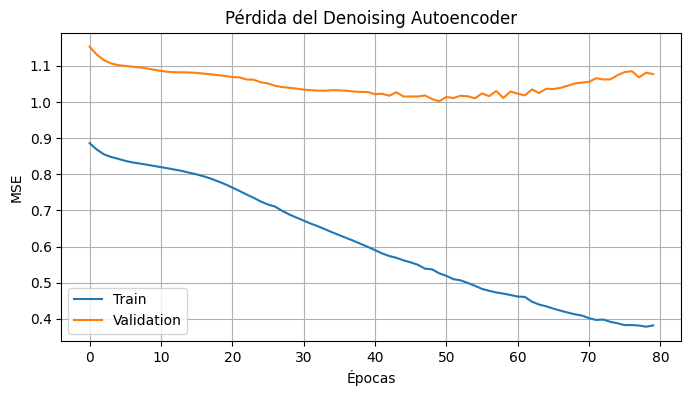

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Pérdida del Denoising Autoencoder")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


## Reconstrucción de la serie temporal

Una vez entrenado, el modelo se utiliza para reconstruir las secuencias
originales. La diferencia entre la señal original y la reconstruida
es la base para calcular el **score de anomalía**.


In [16]:
X_reconstructed = model.predict(X_seq)

reconstruction_error = np.mean(
    np.square(X_seq - X_reconstructed),
    axis=(1, 2)
)

reconstruction_error.shape


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


(61,)

## Score de anomalía

El score de anomalía se define como el error de reconstrucción
normalizado. Valores altos indican observaciones que no encajan
con la dinámica aprendida por el modelo.


In [17]:
anomaly_score = (
    reconstruction_error - reconstruction_error.min()
) / (
    reconstruction_error.max() - reconstruction_error.min()
)

anomaly_score[:5]


array([0.14778973, 0.16562938, 0.13758003, 0.14440703, 0.14072381])

## Evolución temporal del score de anomalía

Este gráfico permite identificar períodos donde la serie presenta
comportamientos atípicos, potencialmente asociados a ruido de observación.


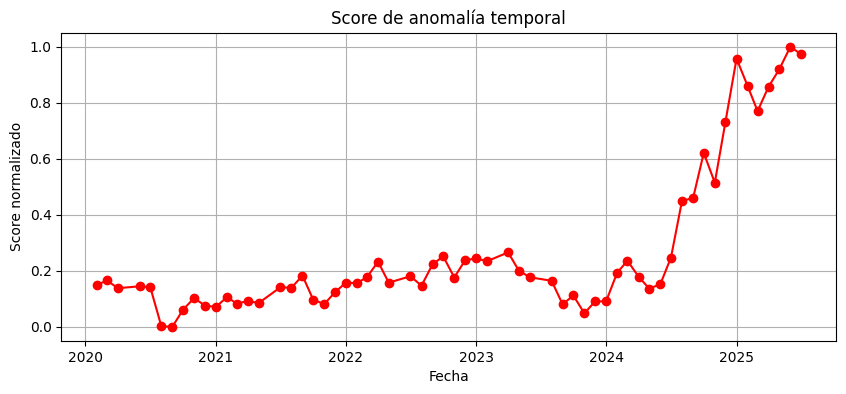

In [18]:
dates_seq = df_model_clean["date"].iloc[WINDOW:].reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(dates_seq, anomaly_score, marker="o", color="red")
plt.title("Score de anomalía temporal")
plt.xlabel("Fecha")
plt.ylabel("Score normalizado")
plt.grid(True)
plt.show()


- Score bajo: comportamiento coherente con la dinámica histórica.
- Score alto: observación potencialmente afectada por ruido o artefactos.

El score **no indica daño al cultivo**, sino **baja confiabilidad del dato**.


In [19]:
feature_idx = {name: i for i, name in enumerate(features)}

ndvi_idx = feature_idx["NDVI"]
ndmi_idx = feature_idx["NDMI"]

ndvi_obs = X_seq[:, -1, ndvi_idx]
ndvi_rec = X_reconstructed[:, -1, ndvi_idx]

ndmi_obs = X_seq[:, -1, ndmi_idx]
ndmi_rec = X_reconstructed[:, -1, ndmi_idx]


## NDVI observado vs NDVI reconstruido

La comparación permite evaluar si el modelo:
- sigue la tendencia general
- atenúa picos espurios
- respeta mínimos fisiológicos reales


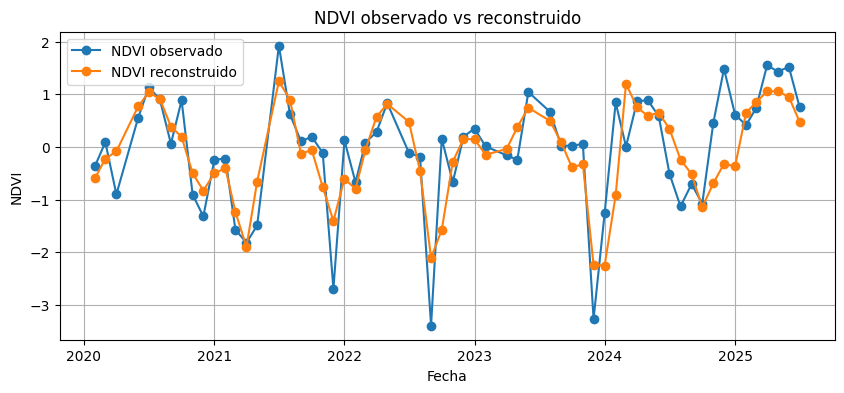

In [20]:
plt.figure(figsize=(10,4))
plt.plot(dates_seq, ndvi_obs, label="NDVI observado", marker="o")
plt.plot(dates_seq, ndvi_rec, label="NDVI reconstruido", marker="o")
plt.title("NDVI observado vs reconstruido")
plt.xlabel("Fecha")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.show()


## NDMI observado vs NDMI reconstruido

En el caso del NDMI, la reconstrucción debe preservar la relación
hidrológica con el NDVI, evitando inconsistencias biofísicas.


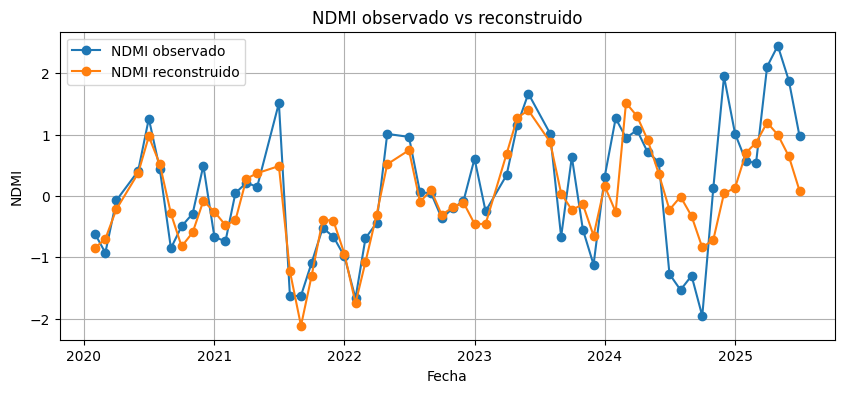

In [21]:
plt.figure(figsize=(10,4))
plt.plot(dates_seq, ndmi_obs, label="NDMI observado", marker="o")
plt.plot(dates_seq, ndmi_rec, label="NDMI reconstruido", marker="o")
plt.title("NDMI observado vs reconstruido")
plt.xlabel("Fecha")
plt.ylabel("NDMI")
plt.legend()
plt.grid(True)
plt.show()


## Uso práctico del score de anomalía

El score de anomalía permite definir reglas simples y transparentes
para decidir cómo utilizar los datos auditados.

Ejemplos:
- utilizar el NDVI observado cuando el score es bajo
- utilizar el NDVI reconstruido cuando el score supera un umbral
- descartar completamente períodos con score extremadamente alto


In [22]:
threshold = 0.6

ndvi_final = np.where(
    anomaly_score > threshold,
    ndvi_rec,
    ndvi_obs
)


## NDVI final auditado

La serie resultante combina:
- datos observados confiables
- reconstrucciones solo cuando existe evidencia de anomalía

Este enfoque evita tanto la sobre-corrección como la aceptación ciega
de datos ruidosos.


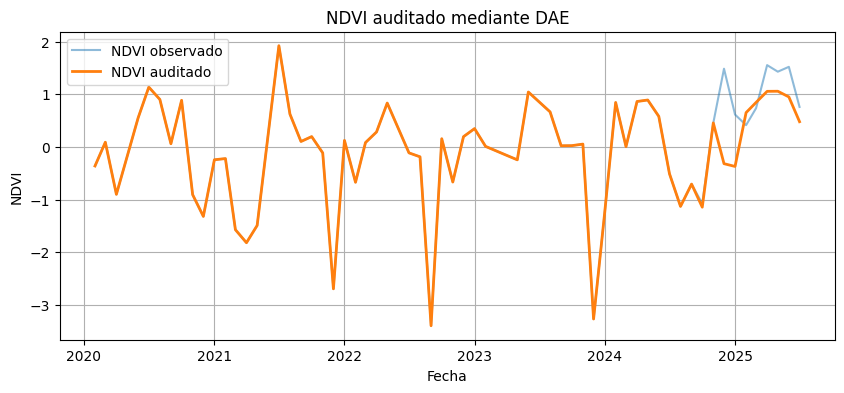

In [23]:
plt.figure(figsize=(10,4))
plt.plot(dates_seq, ndvi_obs, label="NDVI observado", alpha=0.5)
plt.plot(dates_seq, ndvi_final, label="NDVI auditado", linewidth=2)
plt.title("NDVI auditado mediante DAE")
plt.xlabel("Fecha")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.show()


## Conclusiones

Este notebook presenta un enfoque de auditoría de series temporales
agrícolas basado en Denoising Autoencoders temporales.

Principales aportes:
- separación explícita entre ruido de observación y señal ecofisiológica
- generación de un score interpretable de confiabilidad del dato
- preservación de relaciones biofísicas entre índices satelitales
- integración sencilla con modelos productivos existentes

El método no reemplaza el criterio técnico, sino que actúa como una
capa previa de control de calidad, mejorando la base de datos sobre
la cual se toman decisiones.


## Próximos pasos

- evaluación del método en otros cultivos y regiones
- integración directa con sistemas de zonificación productiva
- análisis multianual de estabilidad de zonas
- automatización del flujo para monitoreo continuo
